# Can ICNNs fit arbitrary functions on the sphere?
In this notebook, we train an ICNN and MLP to fit data $\{x_i, y_i\}$ where each of the $x_i$ have unit norm. The networks have the following architectures:

**ICNN**:
$$\begin{align} \phi_i & = \langle A, x_i \rangle + \frac{1}{\sqrt{m}} \sum_{r=1}^m \left( \sigma(w_r^T x_i) - \frac{1}{\sqrt{2\pi}} \right) \qquad \sigma(x) = \max(0, x) \end{align}$$
where $x_i \in \mathbb{R}^2$, $A \in \mathbb{R}^2$, and $w_r \in \mathbb{R}^2$, and the weights are initialized with unit Gaussians. *Both parameters $A$ and the $w_r$ are optimized during training*.

**MLP**:
$$\begin{align} \mu_i & = \frac{1}{\sqrt{m}} \sum_{r=1}^m a_r \sigma(w_r^T x_i) \qquad \sigma(x) = \max(0, x) \end{align}$$
where $x_i \in \mathbb{R}^2$, $a_r \in \mathbb{R}$, and $w_r \in \mathbb{R}^2$, and the weights are initialized with unit Gaussians. *Both parameters $a_r$ and the $w_r$ are optimized during training.*

**Training method**: the ICNN parameters are trained to minimize the objective:

$$\begin{align} \min_{A, \ w_r} \|\phi - y\|_2^2 \end{align}$$

using Adam for 1000 iterations with learning rate 0.001, $\beta_1=0.9$, and $\beta_2 = 0.9$. These values were not optimized for performance in any quantitative way. The MLP parameters are trained with the same objective and hyperparameters.

**How to read this**: each section of the document compares an MLP to an ICNN when fitting a specific dataset. From left to right, each panel shows
1. *Dataset*: values of the function $f : x \to y$ over the entire plane. Each of the red dots is a data point $x_i$ which is assigned $y_i = f(x_i)$.  
2. *Random net output*: output values of the randomly initialized network for each input point in the plane.
3. *Trained net output*: output values of the trained network for each input point in the plane.
4. *Training loss*: a plot of training loss at each gradient descent iteration.

below each panel is a table of ground truth $y_i$ next to the associated network output so that one can directly compare the numerical values. 

**Takeaways**:
1. *Comparison on Quadratic Data*: an example of data which is easy for both the MLP and ICNN to fit. 
2. *Comparison on Checkerboard Data*: an example of data which is expected to be difficult for the ICNN, but which is actually also easy for both the ICNN and MLP to fit. 
3. *Comparison on Cliff Data*: an example of data which the ICNN does not fit. Interestingly, the Du style MLP also does not fit the data, even at width 1000000. 

Questions think about:
1. Why is the cliff data more difficult than the checkerboard data?
2. Are the results on the cliff data in violation of the theory presented in the Du paper?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icnn.nets import IdealICNN, TParams, du_MLP
import torch 
import seaborn as sns
from icnn.heatmaps import DataFunc, make_data, heatmap, apply_net, net_heatmap_comparison
import warnings
warnings.filterwarnings("ignore")

### Comparison on Quadratic Data
Comparison of ICNN and an MLP fitting the data $\{x_i, y_i\}$ where $x_i \in S^{1}$ and $y_i = x_i^T Q x_i$ where $Q$ takes the form 

$$\begin{align*} Q = \begin{bmatrix} 10 & 8 \\ 8 & 10 \end{bmatrix}\end{align*}$$

**MLP with width 10000**:

100%|██████████| 2000/2000 [00:11<00:00, 180.28it/s]


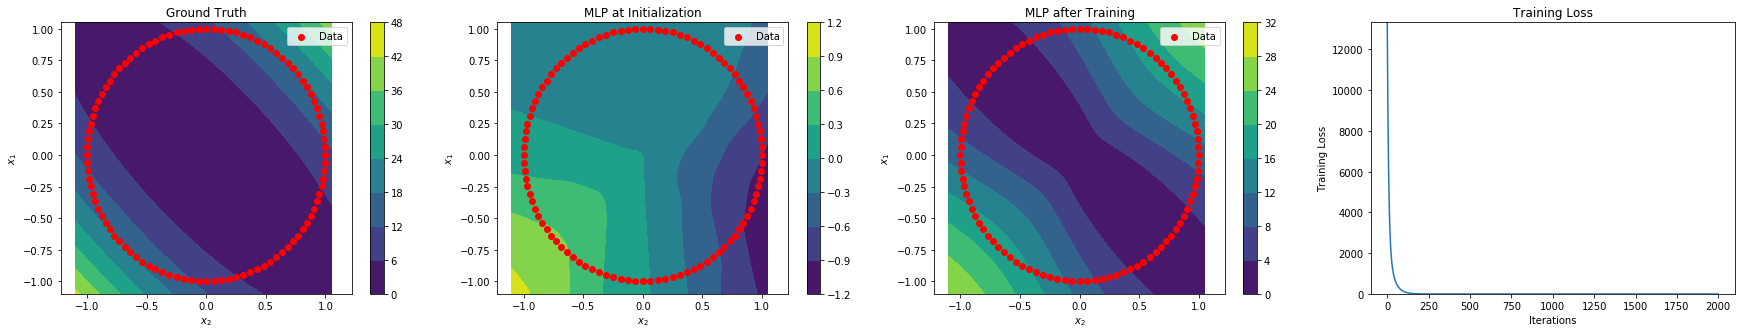

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
True y,10.000000,11.002666,11.989519,12.944996,13.854029,14.702282,15.476377,16.164106,16.754623,17.238616,...,2.391548,2.761384,3.245377,3.835894,4.523623,5.297718,6.145971,7.055004,8.010481,8.997334
Output y,10.006393,11.001571,11.981008,12.930283,13.834628,14.679241,15.453977,16.148770,16.739936,17.226067,...,2.355620,2.744937,3.240713,3.845307,4.544346,5.327497,6.178187,7.078118,8.018983,9.004565


In [2]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="mlp",
                                          width=10000,
                                          data_func=lambda x1, x2: 10 * DataFunc().quadratic(x1, x2, c=0.8),
                                          n_points=100,
                                          sampling_method="regular")

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

**ICNN with width 10000**:

100%|██████████| 2000/2000 [00:08<00:00, 232.22it/s]


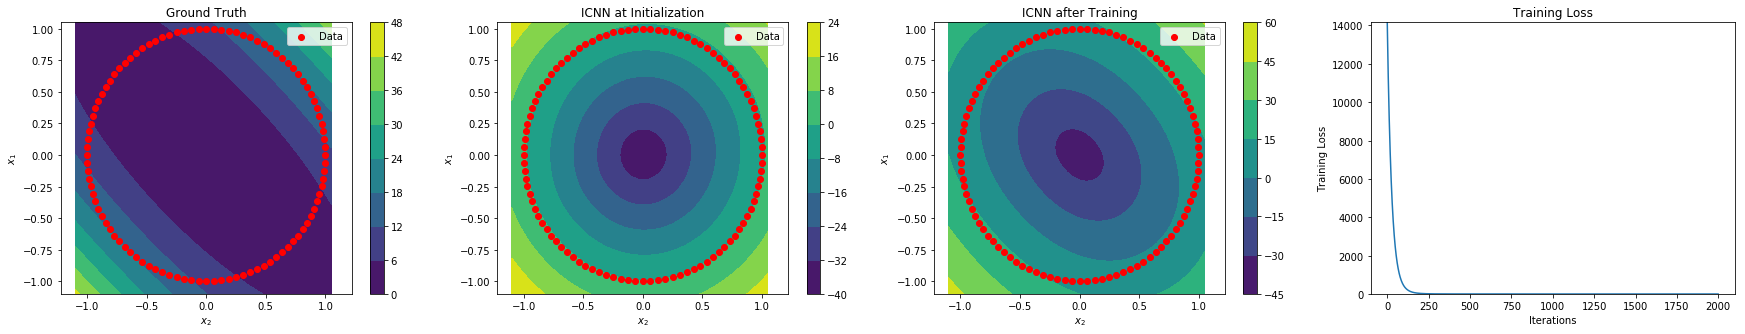

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
True y,10.000000,11.002666,11.989519,12.944996,13.854029,14.702282,15.476377,16.164106,16.754623,17.238616,...,2.391548,2.761384,3.245377,3.835894,4.523623,5.297718,6.145971,7.055004,8.010481,8.997334
Output y,10.025994,11.015304,11.984079,12.920933,13.832279,14.681939,15.464027,16.159085,16.765733,17.258383,...,2.370637,2.751408,3.239648,3.830980,4.523421,5.316853,6.168908,7.083261,8.048276,9.035804


In [3]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="icnn",
                                          width=10000,
                                          data_func=lambda x1, x2: 10 * DataFunc().quadratic(x1, x2, c=0.8),
                                          n_points=100,
                                          sampling_method="regular")

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

### Comparison on Checkerboard Data

Comparison of the ICNN and an MLP fitting the data $\{x_i, y_i\}$ where $x_i \in S^{1}$ and

$$\begin{align*} y_i = \begin{cases}1 & i \text{ odd} \\ -1 & i \text{ even}\end{cases} \end{align*}$$

**MLP with width 10000:**

100%|██████████| 2000/2000 [00:02<00:00, 719.30it/s]


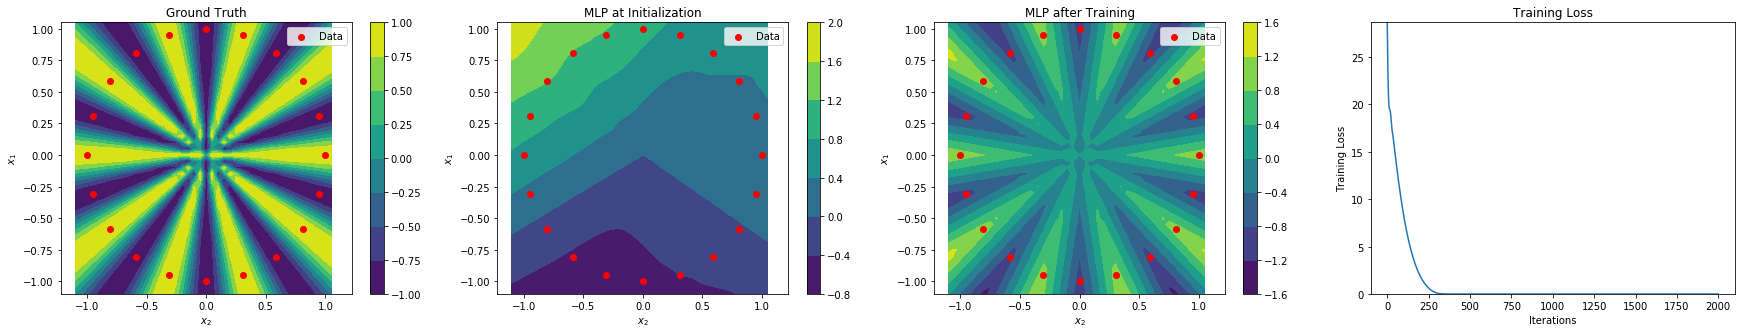

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
True y,1.00000,-1.000000,1.000000,-1.000000,1.00000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.00000,1.000000,-1.000000,1.00000,-1.000000,1.000000,-1.000000,1.000000,-1.000000
Output y,0.99965,-1.001139,0.998217,-1.002236,0.99748,-1.002754,0.997146,-1.002829,0.997436,-1.001969,0.998923,-0.99998,1.001149,-0.997819,1.00295,-0.996766,1.003065,-0.997558,1.001543,-0.999427


In [4]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="mlp",
                                          width=10000,
                                          data_func=lambda x1, x2: DataFunc().checkerboard(x1, x2, n=20),
                                          n_points=20,
                                          sampling_method="regular",
                                          tparams=TParams(lr=0.001, iters=2000, b1=0.9, b2=0.9))

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

**ICNN with width 10000:**

100%|██████████| 2000/2000 [00:20<00:00, 96.68it/s] 


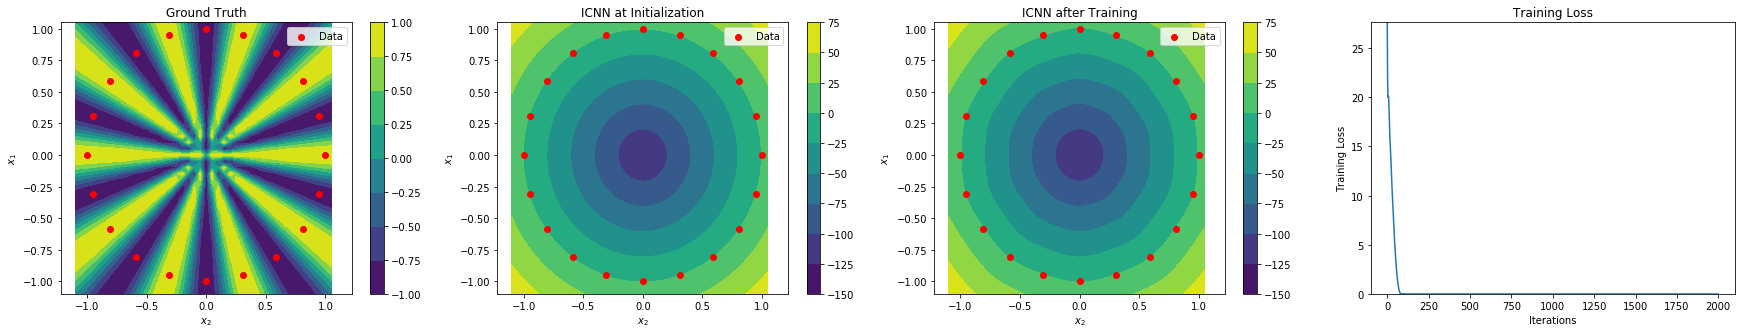

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
True y,1.000000,-1.000000,1.000000,-1.000000,1.00000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.00000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000
Output y,1.000105,-1.001249,0.995935,-1.007012,0.99116,-1.009431,0.991424,-1.006643,0.996012,-1.001667,0.999236,-1.001182,0.99693,-1.005186,0.993639,-1.006542,0.994439,-1.003796,0.998412,-0.999949


In [5]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="icnn",
                                          width=100000,
                                          data_func=lambda x1, x2: DataFunc().checkerboard(x1, x2, n=20),
                                          n_points=20,
                                          sampling_method="regular",
                                          tparams=TParams(lr=0.001, iters=2000, b1=0.9, b2=0.9))

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

### Comparison on Cliff Data

Comparison of an ICNN and an MLP fitting the data $\{x_i, y_i\}$ where $x_i \in S^{1}$ and

$$\begin{align*} y_i = \begin{cases}1 & x_i^{(2)} > 0 \\ -1 & x_i^{(2)} \leq 0 \end{cases} \end{align*}$$
where $x_i^{(2)} = \langle x_i, e_2 \rangle$ is the up-down coordinate in $\mathbb{R}^2$ of $x_i$. 

**MLP with width 10000**:

100%|██████████| 2000/2000 [00:02<00:00, 748.23it/s]


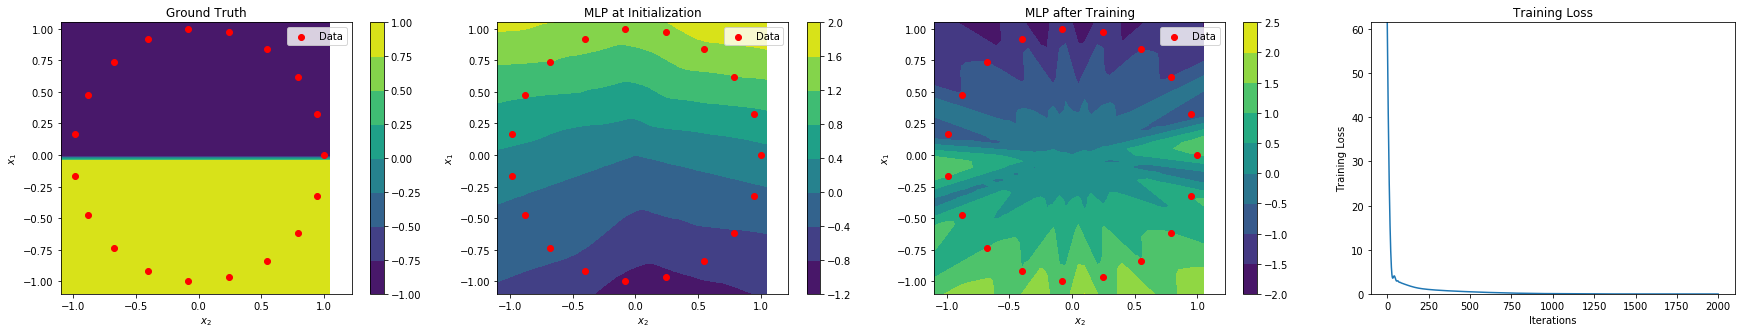

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
True y,1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Output y,0.992953,-0.99493,-1.000359,-1.004424,-1.006704,-1.006606,-1.002525,-0.998178,-0.990689,-0.986926,1.002251,0.995713,1.005151,1.005225,1.006652,1.004587,1.000351,0.996862,0.987876


In [6]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="mlp",
                                          width=10000,
                                          data_func=DataFunc().cliff,
                                          n_points=19,
                                          sampling_method="regular",
                                          tparams=TParams(lr=0.001, iters=2000, b1=0.9, b2=0.9))

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

**Angular Density Plot of MLP-10000 on Cliff-19**

This plot shows the angles that each $w_r \in \mathbb{R}^2$ makes with the $x$-axis. For each weight, its angle is computed and added to this density plot.

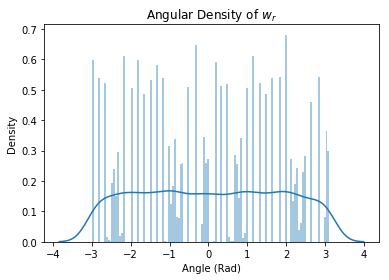

In [7]:
weights = [w.detach().cpu().numpy() for w in net.Ws[0]]
weight_angles = [np.arctan2(w[0], w[1]) for w in weights]


sns.distplot(weight_angles, bins=np.arange(-np.pi, np.pi, 0.05))

hist = np.histogram(weight_angles, bins=np.arange(-np.pi, np.pi, 0.05))
plt.xlabel("Angle (Rad)")
plt.title("Angular Density of $w_r$")
plt.show()

**Training and Angular Density of MLP-10000 on Cliff-20 and Cliff-11**

Cliff-20:

100%|██████████| 2000/2000 [00:02<00:00, 885.16it/s]


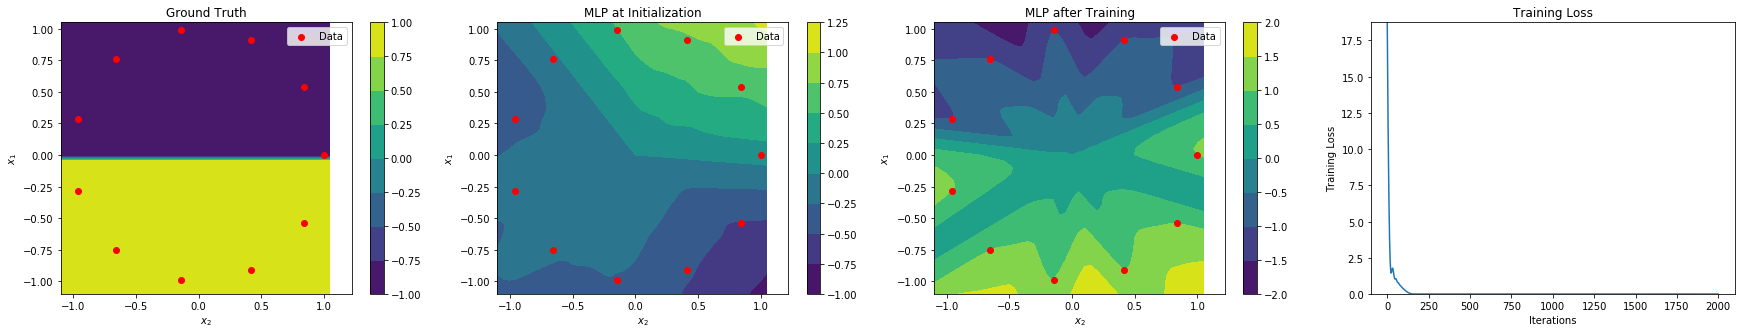

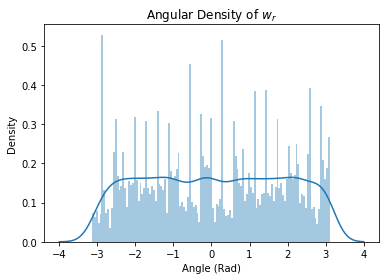

In [8]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="mlp",
                                          width=10000,
                                          data_func=DataFunc().cliff,
                                          n_points=11,
                                          sampling_method="regular",
                                          tparams=TParams(lr=0.001, iters=2000, b1=0.9, b2=0.9))

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

weights = [w.detach().cpu().numpy() for w in net.Ws[0]]
weight_angles = [np.arctan2(w[0], w[1]) for w in weights]


sns.distplot(weight_angles, bins=np.arange(-np.pi, np.pi, 0.05))

hist = np.histogram(weight_angles, bins=np.arange(-np.pi, np.pi, 0.05))
plt.xlabel("Angle (Rad)")
plt.title("Angular Density of $w_r$")
plt.show()

Cliff-11:

100%|██████████| 2000/2000 [00:02<00:00, 744.74it/s]


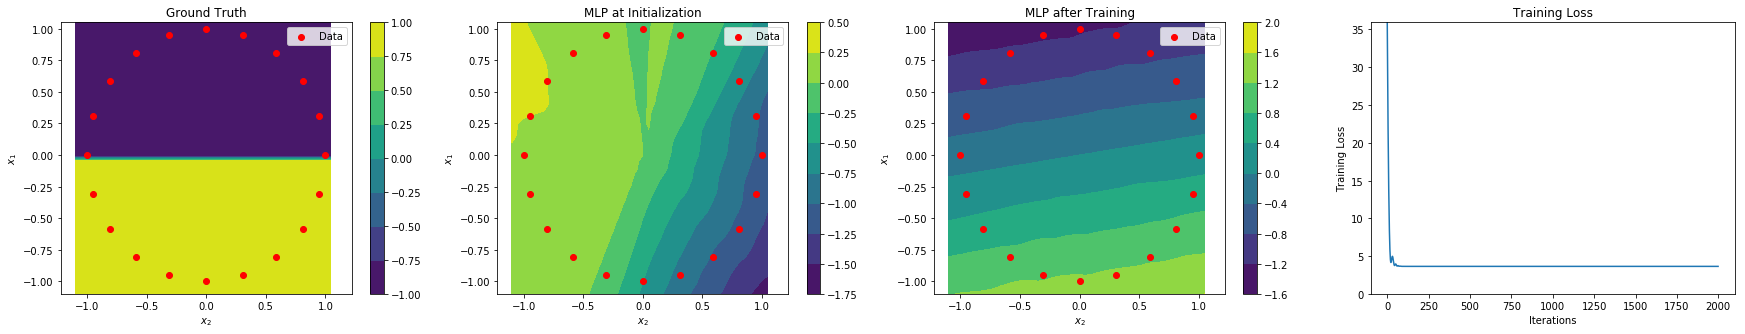

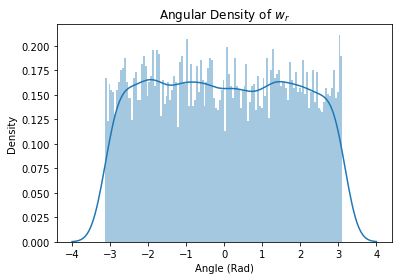

In [9]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="mlp",
                                          width=10000,
                                          data_func=DataFunc().cliff,
                                          n_points=20,
                                          sampling_method="regular",
                                          tparams=TParams(lr=0.001, iters=2000, b1=0.9, b2=0.9))

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

weights = [w.detach().cpu().numpy() for w in net.Ws[0]]
weight_angles = [np.arctan2(w[0], w[1]) for w in weights]
sns.distplot(weight_angles, bins=np.arange(-np.pi, np.pi, 0.05))
plt.xlabel("Angle (Rad)")
plt.title("Angular Density of $w_r$")
plt.show()

**ICNN with width 100000**: (note: width is greater than that of MLP)

100%|██████████| 2000/2000 [00:19<00:00, 102.54it/s]


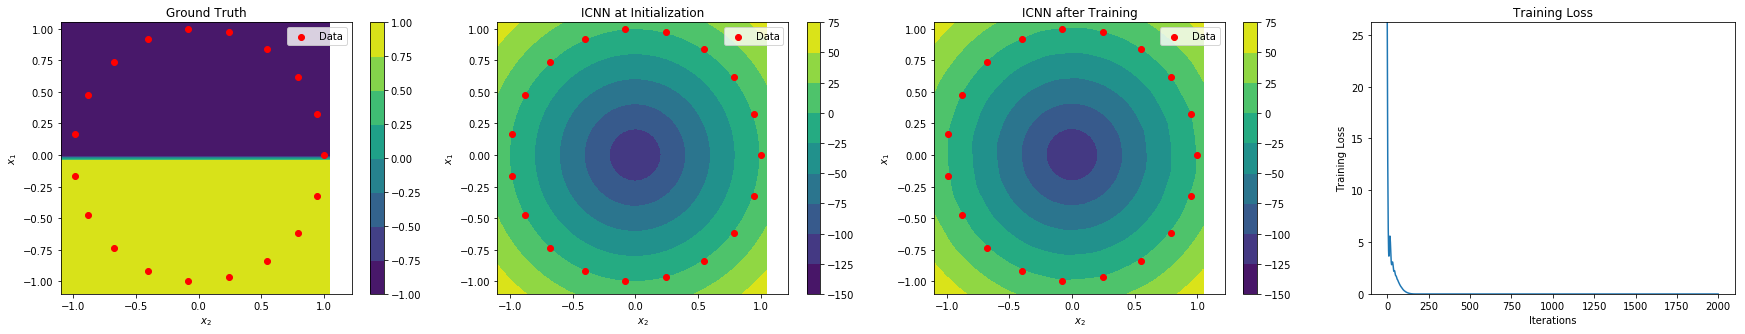

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
True y,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Output y,1.008469,-0.991665,-0.993174,-0.995771,-0.998638,-1.00078,-1.001433,-1.001156,-1.000335,-0.999498,1.000796,1.000436,0.999687,0.998962,0.998761,0.999943,1.002184,1.004821,1.007135


In [10]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="icnn",
                                          width=100000,
                                          data_func=DataFunc().cliff,
                                          n_points=19,
                                          sampling_method="regular",
                                          tparams=TParams(lr=0.001, iters=2000, b1=0.9, b2=0.9))

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

100%|██████████| 2000/2000 [00:19<00:00, 103.36it/s]


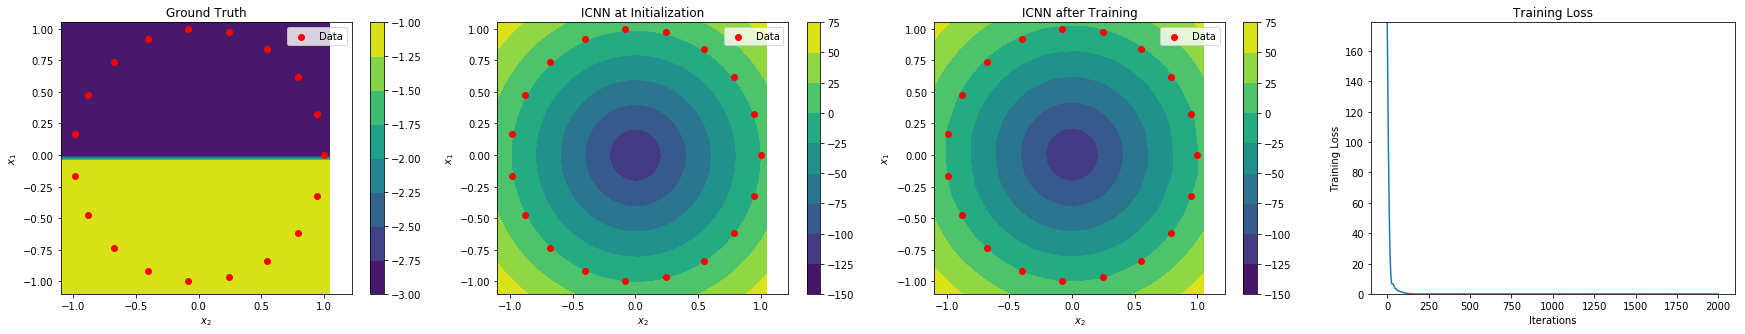

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
True y,-1.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
Output y,-0.997937,-2.998995,-3.000035,-3.000996,-3.001719,-3.002296,-3.002696,-3.002838,-3.002655,-3.002293,-1.00144,-1.000311,-0.999063,-0.997821,-0.996796,-0.996128,-0.995922,-0.996213,-0.996932


In [11]:
x, true_y, net_y, net = net_heatmap_comparison(net_arch="icnn",
                                          width=100000,
                                          data_func=DataFunc().trench,
                                          n_points=19,
                                          sampling_method="regular",
                                          tparams=TParams(lr=0.001, iters=2000, b1=0.9, b2=0.9))

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df